# Coursework for Cardiac MR Image Segmentation (2021-2022)

After you have gone through the coursework description, this tutorial is designed to further helps you understand the problem and therefore enable you to propose a good solution for this coursework. You will learn:

* how to load and save images with OpenCV
* how to train a segmentation model with Pytorch
* how to evaluate the trained model

## 1. Load, show, and save images with OpenCV

OpenCV is an open-source computer vision library which helps us to manipulate image data. In this section, we will cover:
* Loading an image from file with imread()
* Displaying the image with matplotlib plt.imshow()
* Saving an image with imwrite()

For a more comprehensive study of OpenCV, we encourage you to check the official [OpenCV documentation](https://docs.opencv.org/master/index.html).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device  :',device)

device  : cuda


In [3]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

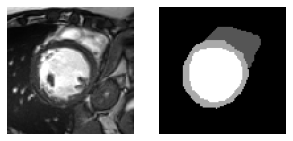

(96, 96)


In [4]:

import os
import cv2 #import OpenCV

data_dir = '/content/drive/MyDrive/data/train/'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)
print(image.shape)

Note: You will no doubt notice that the mask images appear to be completely black with no sign of any segmentations. This is because the max intensity of pixels in an 8-bit png image is 255 and your image viewer software only sees 255 as white. For those values close to zero, you will only see dark values. This is the case for our masks as the background, the right ventricle, the myocardium, and the left ventricle in each image are 0, 1, 2, and 3, respectively. All of which are close to zero. If we multiply the original mask by 85 and save the result to the directory where this code is, we can see the heart indeed shows up. 

## 2 Define a segmentation model with Pytorch

In this section, we expect you to learn how to:
* Define a Segmentation Model
* Define a DataLoader that inputs images to the Model
* Define training parameters and train the model
* Test the trained model with a new input image

### 2.1 Define a DataLoader

Below we provide you with a dataloader to use in your assigment. You will only need to focus on the development of your model and loss function.



In [5]:

import torch
import torch.utils.data as data
import cv2
import os
from glob import glob
path = '/content/drive/MyDrive/data/train'


class TrainDataset(data.Dataset):
    def __init__(self, root=path):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        #print(self.img_files)
        self.mask_files = []
        #print(self.img_files)
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()    #tensor vlaues for data( image) and label( mask) is returned.

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)


### 2.2 Define a Segmenatation Model

You will need to define your CNN model for segmentation below

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   

class UNet(nn.Module):

    def __init__(self, n_class=4):
        super().__init__()

        self.dconv_pre = double_conv(1,3)       
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512) 
       # self.dconv_down5 = double_conv(512, 1024)       

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):

        convpre = self.dconv_pre(x) #not maxpooling here
        conv1 = self.dconv_down1(convpre)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

class CNNSEG(nn.Module):

    def __init__(self, n_class=4):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 3)
        self.dconv_down2 = double_conv(3, 64)
        self.dconv_down3 = double_conv(64, 128)
        self.dconv_down4 = double_conv(128, 256)
        self.dconv_down5 = double_conv(256, 512)          

        self.maxpool = nn.MaxPool2d(2) #kernel size two..stride = none

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        
       # self.dconv_up3 = double_conv(256 + 512, 256)
        #self.dconv_up2 = double_conv(128 + 256, 128)
        #self.dconv_up1 = double_conv(128 + 64, 64)
        self.dconv_up4 = double_conv(512+512, 512)
        self.dconv_up3 = double_conv()
        self.dconv_up2 = double_conv(512+512, 512)
        self.dconv_up1 = double_conv(512+512, 512)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4) 

        conv5 = self.dconv_down5(x)

        x = self.upsample(conv5)        #left with 512 channels and ..becomes 12 * 12
        x = torch.cat([x, conv4], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out


#https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.py

model = UNet() # We can now create a model using your defined segmentation model

In [7]:



model = model.to(device)

model

UNet(
  (dconv_pre): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): 

In [8]:
from torchsummary import  summary
#help to view the visualisation of the model

summary(model,input_size=(1,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 96, 96]              30
              ReLU-2            [-1, 3, 96, 96]               0
            Conv2d-3            [-1, 3, 96, 96]              84
              ReLU-4            [-1, 3, 96, 96]               0
            Conv2d-5           [-1, 64, 96, 96]           1,792
              ReLU-6           [-1, 64, 96, 96]               0
            Conv2d-7           [-1, 64, 96, 96]          36,928
              ReLU-8           [-1, 64, 96, 96]               0
         MaxPool2d-9           [-1, 64, 48, 48]               0
           Conv2d-10          [-1, 128, 48, 48]          73,856
             ReLU-11          [-1, 128, 48, 48]               0
           Conv2d-12          [-1, 128, 48, 48]         147,584
             ReLU-13          [-1, 128, 48, 48]               0
        MaxPool2d-14          [-1, 128,

### 2.3 Define a Loss function and optimizer

You will need to define a loss function and an optimizer. torch.nn has a variety of readymade loss functions, although you may wish to create your own instead. torch.optim has a variety of optimizers, it is advised that you use one of these.

In [9]:

import torch.optim as optim
from torch.optim import lr_scheduler

"""
def dice_loss(pred,target, smooth = 1.):

    pred = pred.contiguous()
    target = target.contiguous()    
    
    #When you call contiguous(), it actually makes a copy of the tensor such that the order of its elements in memory is the same as if it had been created from scratch with the same data.

    #Normally you don't need to worry about this. You're generally safe to assume everything will work, and wait until you get a RuntimeError: input is not contiguous where PyTorch expects a contiguous tensor to add a call to contiguous().

    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()


criterion = nn.CrossEntropyLoss()

# so we have two types of loss the dice loss and cross entropy loss

def optimizer():
  return optim.Adam(filter( lambda p:p.requires_grad,model.parameters()),lr=1e-4)

optimizer_ft = optimizer()
def exp_lr_scheduler():
  return lr_scheduler.StepLR(optimizer_ft,step_size=30,gamma=0.1)
"""


"\ndef dice_loss(pred,target, smooth = 1.):\n\n    pred = pred.contiguous()\n    target = target.contiguous()    \n    \n    #When you call contiguous(), it actually makes a copy of the tensor such that the order of its elements in memory is the same as if it had been created from scratch with the same data.\n\n    #Normally you don't need to worry about this. You're generally safe to assume everything will work, and wait until you get a RuntimeError: input is not contiguous where PyTorch expects a contiguous tensor to add a call to contiguous().\n\n    \n\n    intersection = (pred * target).sum(dim=2).sum(dim=2)\n    \n    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))\n    \n    return loss.mean()\n\n\ncriterion = nn.CrossEntropyLoss()\n\n# so we have two types of loss the dice loss and cross entropy loss\n\ndef optimizer():\n  return optim.Adam(filter( lambda p:p.requires_grad,model.parameters()),lr=1e-4)\n\noptimiz

### 2.4 Training

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

In [10]:
# https://github.com/milesial/Pytorch-UNet/blob/master/utils/dice_score.py

import torch
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)


Epoch 1/5: 3img [00:00, 12.87img/s, loss (batch)=0.613]

train loss 0.8183436393737793  step : 1  epoch : 0
train loss 0.6835205554962158  step : 2  epoch : 0
train loss 0.6127526164054871  step : 3  epoch : 0


Epoch 1/5: 7img [00:00, 14.00img/s, loss (batch)=0.721]

train loss 0.47611162066459656  step : 4  epoch : 0
train loss 0.4385381042957306  step : 5  epoch : 0
train loss 0.9589266180992126  step : 6  epoch : 0
train loss 0.7214989066123962  step : 7  epoch : 0


Epoch 1/5: 11img [00:00, 15.73img/s, loss (batch)=0.671]

train loss 0.5605876445770264  step : 8  epoch : 0
train loss 0.7664786577224731  step : 9  epoch : 0
train loss 0.7503761649131775  step : 10  epoch : 0
train loss 0.6711764335632324  step : 11  epoch : 0


Epoch 1/5: 15img [00:01, 16.65img/s, loss (batch)=0.641]

train loss 0.678788959980011  step : 12  epoch : 0
train loss 0.5807302594184875  step : 13  epoch : 0
train loss 0.7243580222129822  step : 14  epoch : 0
train loss 0.6405029296875  step : 15  epoch : 0


Epoch 1/5: 19img [00:01, 17.65img/s, loss (batch)=0.795]

train loss 0.7519734501838684  step : 16  epoch : 0
train loss 0.7513859272003174  step : 17  epoch : 0
train loss 0.3325282335281372  step : 18  epoch : 0
train loss 0.7945687174797058  step : 19  epoch : 0


Epoch 1/5: 23img [00:01, 17.71img/s, loss (batch)=0.412]

train loss 1.0963718891143799  step : 20  epoch : 0
train loss 0.5776941776275635  step : 21  epoch : 0
train loss 0.4254642724990845  step : 22  epoch : 0
train loss 0.4123826026916504  step : 23  epoch : 0


Epoch 1/5: 27img [00:01, 18.21img/s, loss (batch)=0.61] 

train loss 0.5812180638313293  step : 24  epoch : 0
train loss 0.8086180686950684  step : 25  epoch : 0
train loss 0.908273458480835  step : 26  epoch : 0
train loss 0.6102410554885864  step : 27  epoch : 0


Epoch 1/5: 31img [00:01, 18.21img/s, loss (batch)=0.619]

train loss 0.5708301067352295  step : 28  epoch : 0
train loss 0.6432778835296631  step : 29  epoch : 0
train loss 0.9136918187141418  step : 30  epoch : 0
train loss 0.6191112399101257  step : 31  epoch : 0


Epoch 1/5: 35img [00:02, 18.48img/s, loss (batch)=0.62] 

train loss 0.5661880373954773  step : 32  epoch : 0
train loss 0.5842732191085815  step : 33  epoch : 0
train loss 0.5166585445404053  step : 34  epoch : 0
train loss 0.6204760074615479  step : 35  epoch : 0


Epoch 1/5: 39img [00:02, 18.02img/s, loss (batch)=0.983]

train loss 0.7267071008682251  step : 36  epoch : 0
train loss 0.6242431998252869  step : 37  epoch : 0
train loss 0.6976458430290222  step : 38  epoch : 0
train loss 0.9832804203033447  step : 39  epoch : 0


Epoch 1/5: 43img [00:02, 17.87img/s, loss (batch)=0.929]

train loss 0.6497890949249268  step : 40  epoch : 0
train loss 0.8233545422554016  step : 41  epoch : 0
train loss 0.7897048592567444  step : 42  epoch : 0
train loss 0.9294817447662354  step : 43  epoch : 0


Epoch 1/5: 47img [00:02, 18.11img/s, loss (batch)=0.836]

train loss 0.6034273505210876  step : 44  epoch : 0
train loss 0.552101731300354  step : 45  epoch : 0
train loss 0.5239865183830261  step : 46  epoch : 0
train loss 0.836166501045227  step : 47  epoch : 0


Epoch 1/5: 51img [00:02, 18.42img/s, loss (batch)=0.792]

train loss 0.45745012164115906  step : 48  epoch : 0
train loss 0.6909849643707275  step : 49  epoch : 0
train loss 0.5717008113861084  step : 50  epoch : 0
train loss 0.7918762564659119  step : 51  epoch : 0


Epoch 1/5: 55img [00:03, 18.37img/s, loss (batch)=0.668]

train loss 0.5301230549812317  step : 52  epoch : 0
train loss 0.9715808033943176  step : 53  epoch : 0
train loss 0.9048854112625122  step : 54  epoch : 0
train loss 0.667611837387085  step : 55  epoch : 0


Epoch 1/5: 59img [00:03, 18.56img/s, loss (batch)=0.507]

train loss 0.7018997669219971  step : 56  epoch : 0
train loss 0.7483407258987427  step : 57  epoch : 0
train loss 0.7783150672912598  step : 58  epoch : 0
train loss 0.5069925785064697  step : 59  epoch : 0


Epoch 1/5: 63img [00:03, 18.40img/s, loss (batch)=0.506]

train loss 0.8313260674476624  step : 60  epoch : 0
train loss 0.7117928266525269  step : 61  epoch : 0
train loss 1.1077810525894165  step : 62  epoch : 0
train loss 0.5056724548339844  step : 63  epoch : 0


Epoch 1/5: 67img [00:03, 18.33img/s, loss (batch)=0.42] 

train loss 0.6747386455535889  step : 64  epoch : 0
train loss 0.6431607007980347  step : 65  epoch : 0
train loss 0.5844093561172485  step : 66  epoch : 0
train loss 0.41996607184410095  step : 67  epoch : 0


Epoch 1/5: 71img [00:04, 18.46img/s, loss (batch)=0.381]

train loss 0.49560970067977905  step : 68  epoch : 0
train loss 0.680573582649231  step : 69  epoch : 0
train loss 0.7174793481826782  step : 70  epoch : 0
train loss 0.38066810369491577  step : 71  epoch : 0


Epoch 1/5: 75img [00:04, 18.09img/s, loss (batch)=0.539]

train loss 0.7166509628295898  step : 72  epoch : 0
train loss 0.7701235413551331  step : 73  epoch : 0
train loss 0.7547552585601807  step : 74  epoch : 0
train loss 0.5385016202926636  step : 75  epoch : 0


Epoch 1/5: 79img [00:04, 18.48img/s, loss (batch)=0.638]

train loss 0.7670869827270508  step : 76  epoch : 0
train loss 0.5391544699668884  step : 77  epoch : 0
train loss 0.7102377414703369  step : 78  epoch : 0
train loss 0.6379719972610474  step : 79  epoch : 0


Epoch 1/5: 83img [00:04, 18.55img/s, loss (batch)=0.585]

train loss 0.6941014528274536  step : 80  epoch : 0
train loss 0.5671170353889465  step : 81  epoch : 0
train loss 0.5788252949714661  step : 82  epoch : 0
train loss 0.584724485874176  step : 83  epoch : 0


Epoch 1/5: 87img [00:04, 17.85img/s, loss (batch)=0.692]

train loss 0.4085420072078705  step : 84  epoch : 0
train loss 0.7592847347259521  step : 85  epoch : 0
train loss 0.7232570648193359  step : 86  epoch : 0
train loss 0.692027747631073  step : 87  epoch : 0


Epoch 1/5: 91img [00:05, 18.02img/s, loss (batch)=0.467]

train loss 0.6125439405441284  step : 88  epoch : 0
train loss 0.6741365790367126  step : 89  epoch : 0
train loss 0.44145622849464417  step : 90  epoch : 0
train loss 0.46716976165771484  step : 91  epoch : 0


Epoch 1/5: 95img [00:05, 18.48img/s, loss (batch)=0.937]

train loss 0.6416856050491333  step : 92  epoch : 0
train loss 0.6387309432029724  step : 93  epoch : 0
train loss 0.4724166691303253  step : 94  epoch : 0
train loss 0.9367851614952087  step : 95  epoch : 0


Epoch 1/5: 99img [00:05, 18.36img/s, loss (batch)=0.721]

train loss 1.1221773624420166  step : 96  epoch : 0
train loss 0.6577236652374268  step : 97  epoch : 0
train loss 0.4362472593784332  step : 98  epoch : 0
train loss 0.720648467540741  step : 99  epoch : 0


Epoch 1/5: 100img [00:05, 17.51img/s, loss (batch)=0.592]


train loss 0.591761589050293  step : 100  epoch : 0


Epoch 2/5: 1img [00:00,  9.32img/s, loss (batch)=0.749]

train loss 0.7494714260101318  step : 101  epoch : 1


Epoch 2/5: 4img [00:00, 15.34img/s, loss (batch)=0.442]

train loss 0.6570655107498169  step : 102  epoch : 1
train loss 0.5043351054191589  step : 103  epoch : 1
train loss 0.442388117313385  step : 104  epoch : 1


Epoch 2/5: 6img [00:00, 17.57img/s, loss (batch)=0.726]

train loss 0.7258979678153992  step : 105  epoch : 1


Epoch 2/5: 8img [00:00, 17.83img/s, loss (batch)=0.688]

train loss 0.6742727756500244  step : 106  epoch : 1
train loss 0.6847723126411438  step : 107  epoch : 1
train loss 0.6881474256515503  step : 108  epoch : 1


Epoch 2/5: 10img [00:00, 18.27img/s, loss (batch)=0.928]

train loss 0.9284610748291016  step : 109  epoch : 1


Epoch 2/5: 12img [00:00, 18.45img/s, loss (batch)=0.69] 

train loss 0.5120118856430054  step : 110  epoch : 1
train loss 0.9664313197135925  step : 111  epoch : 1
train loss 0.6900615096092224  step : 112  epoch : 1


Epoch 2/5: 14img [00:00, 18.33img/s, loss (batch)=0.778]

train loss 0.7777792811393738  step : 113  epoch : 1


Epoch 2/5: 16img [00:00, 18.06img/s, loss (batch)=0.428]

train loss 0.5187991261482239  step : 114  epoch : 1
train loss 0.5857937932014465  step : 115  epoch : 1
train loss 0.4275830090045929  step : 116  epoch : 1


Epoch 2/5: 17img [00:00, 18.06img/s, loss (batch)=0.558]

train loss 0.5578986406326294  step : 117  epoch : 1


Epoch 2/5: 20img [00:01, 18.11img/s, loss (batch)=0.818]

train loss 0.6384040117263794  step : 118  epoch : 1
train loss 0.7666855454444885  step : 119  epoch : 1
train loss 0.8179019689559937  step : 120  epoch : 1


Epoch 2/5: 22img [00:01, 17.99img/s, loss (batch)=0.583]

train loss 0.5825684070587158  step : 121  epoch : 1


Epoch 2/5: 24img [00:01, 17.95img/s, loss (batch)=0.711]

train loss 0.9310739040374756  step : 122  epoch : 1
train loss 0.7261224389076233  step : 123  epoch : 1
train loss 0.7105126976966858  step : 124  epoch : 1


Epoch 2/5: 26img [00:01, 18.16img/s, loss (batch)=0.903]

train loss 0.9030532836914062  step : 125  epoch : 1


Epoch 2/5: 28img [00:01, 18.31img/s, loss (batch)=0.575]

train loss 0.9760506749153137  step : 126  epoch : 1
train loss 0.4740142822265625  step : 127  epoch : 1
train loss 0.5745358467102051  step : 128  epoch : 1


Epoch 2/5: 30img [00:01, 18.47img/s, loss (batch)=0.754]

train loss 0.7538692951202393  step : 129  epoch : 1


Epoch 2/5: 32img [00:01, 18.67img/s, loss (batch)=0.413]

train loss 0.6282609701156616  step : 130  epoch : 1
train loss 0.6179274320602417  step : 131  epoch : 1
train loss 0.4126061201095581  step : 132  epoch : 1


Epoch 2/5: 34img [00:01, 18.58img/s, loss (batch)=0.604]

train loss 0.6035799384117126  step : 133  epoch : 1


Epoch 2/5: 36img [00:02, 18.18img/s, loss (batch)=0.654]

train loss 0.7272804975509644  step : 134  epoch : 1
train loss 0.6158167719841003  step : 135  epoch : 1
train loss 0.653809130191803  step : 136  epoch : 1


Epoch 2/5: 37img [00:02, 18.18img/s, loss (batch)=0.45] 

train loss 0.44992196559906006  step : 137  epoch : 1


Epoch 2/5: 40img [00:02, 17.54img/s, loss (batch)=0.585]

train loss 0.5481550097465515  step : 138  epoch : 1
train loss 0.5686252117156982  step : 139  epoch : 1
train loss 0.5846025943756104  step : 140  epoch : 1


Epoch 2/5: 41img [00:02, 17.54img/s, loss (batch)=0.584]

train loss 0.583744466304779  step : 141  epoch : 1


Epoch 2/5: 44img [00:02, 17.92img/s, loss (batch)=0.535]

train loss 0.6857966184616089  step : 142  epoch : 1
train loss 0.5281931757926941  step : 143  epoch : 1
train loss 0.5352516770362854  step : 144  epoch : 1


Epoch 2/5: 46img [00:02, 18.34img/s, loss (batch)=0.623]

train loss 0.6234138011932373  step : 145  epoch : 1


Epoch 2/5: 48img [00:02, 18.36img/s, loss (batch)=0.639]

train loss 0.6943078637123108  step : 146  epoch : 1
train loss 0.8304979801177979  step : 147  epoch : 1
train loss 0.6388937830924988  step : 148  epoch : 1


Epoch 2/5: 50img [00:02, 18.19img/s, loss (batch)=0.431]

train loss 0.4310443103313446  step : 149  epoch : 1


Epoch 2/5: 52img [00:02, 18.05img/s, loss (batch)=0.796]

train loss 0.7162054181098938  step : 150  epoch : 1
train loss 0.40552183985710144  step : 151  epoch : 1
train loss 0.7961958646774292  step : 152  epoch : 1


Epoch 2/5: 54img [00:03, 18.01img/s, loss (batch)=1.12]

train loss 1.1169896125793457  step : 153  epoch : 1


Epoch 2/5: 56img [00:03, 17.94img/s, loss (batch)=0.507]

train loss 0.6306025981903076  step : 154  epoch : 1
train loss 0.6178696155548096  step : 155  epoch : 1
train loss 0.5074754357337952  step : 156  epoch : 1


Epoch 2/5: 58img [00:03, 17.94img/s, loss (batch)=0.775]

train loss 0.774784505367279  step : 157  epoch : 1


Epoch 2/5: 60img [00:03, 18.11img/s, loss (batch)=0.61] 

train loss 0.4674404561519623  step : 158  epoch : 1
train loss 0.5633596777915955  step : 159  epoch : 1
train loss 0.6102211475372314  step : 160  epoch : 1


Epoch 2/5: 62img [00:03, 18.02img/s, loss (batch)=0.557]

train loss 0.5572249889373779  step : 161  epoch : 1


Epoch 2/5: 64img [00:03, 18.21img/s, loss (batch)=0.948]

train loss 0.816321074962616  step : 162  epoch : 1
train loss 0.37323492765426636  step : 163  epoch : 1
train loss 0.9483650922775269  step : 164  epoch : 1


Epoch 2/5: 66img [00:03, 18.08img/s, loss (batch)=0.772]

train loss 0.7724922299385071  step : 165  epoch : 1


Epoch 2/5: 68img [00:03, 18.33img/s, loss (batch)=0.656]

train loss 0.6609359383583069  step : 166  epoch : 1
train loss 0.5993476510047913  step : 167  epoch : 1
train loss 0.6558800935745239  step : 168  epoch : 1


Epoch 2/5: 70img [00:03, 18.29img/s, loss (batch)=0.708]

train loss 0.7082988023757935  step : 169  epoch : 1


Epoch 2/5: 72img [00:04, 18.12img/s, loss (batch)=0.669]

train loss 0.711571455001831  step : 170  epoch : 1
train loss 0.5933418273925781  step : 171  epoch : 1
train loss 0.6690662503242493  step : 172  epoch : 1


Epoch 2/5: 74img [00:04, 18.09img/s, loss (batch)=0.536]

train loss 0.5356991291046143  step : 173  epoch : 1


Epoch 2/5: 76img [00:04, 18.45img/s, loss (batch)=0.642]

train loss 0.7380369901657104  step : 174  epoch : 1
train loss 0.7180958986282349  step : 175  epoch : 1
train loss 0.6419188380241394  step : 176  epoch : 1


Epoch 2/5: 78img [00:04, 18.66img/s, loss (batch)=0.705]

train loss 0.7053308486938477  step : 177  epoch : 1


Epoch 2/5: 80img [00:04, 18.37img/s, loss (batch)=1.08] 

train loss 0.6676058173179626  step : 178  epoch : 1
train loss 0.647581934928894  step : 179  epoch : 1
train loss 1.0845928192138672  step : 180  epoch : 1


Epoch 2/5: 82img [00:04, 18.83img/s, loss (batch)=0.756]

train loss 0.7558915615081787  step : 181  epoch : 1


Epoch 2/5: 84img [00:04, 18.63img/s, loss (batch)=0.598]

train loss 0.8379411697387695  step : 182  epoch : 1
train loss 1.0086078643798828  step : 183  epoch : 1
train loss 0.5979852080345154  step : 184  epoch : 1


Epoch 2/5: 86img [00:04, 18.54img/s, loss (batch)=0.781]

train loss 0.7812998294830322  step : 185  epoch : 1


Epoch 2/5: 88img [00:04, 18.42img/s, loss (batch)=0.442]

train loss 0.5895295739173889  step : 186  epoch : 1
train loss 0.7541285753250122  step : 187  epoch : 1
train loss 0.4423133134841919  step : 188  epoch : 1


Epoch 2/5: 90img [00:04, 17.92img/s, loss (batch)=0.901]

train loss 0.9014136791229248  step : 189  epoch : 1


Epoch 2/5: 93img [00:05, 18.85img/s, loss (batch)=0.674]

train loss 0.597157895565033  step : 190  epoch : 1
train loss 0.5310513973236084  step : 191  epoch : 1
train loss 0.6735279560089111  step : 192  epoch : 1


Epoch 2/5: 93img [00:05, 18.85img/s, loss (batch)=0.476]

train loss 0.47551217675209045  step : 193  epoch : 1


Epoch 2/5: 97img [00:05, 18.57img/s, loss (batch)=0.702]

train loss 0.758284330368042  step : 194  epoch : 1
train loss 0.49562570452690125  step : 195  epoch : 1
train loss 0.7021648287773132  step : 196  epoch : 1


Epoch 2/5: 97img [00:05, 18.57img/s, loss (batch)=0.59] 

train loss 0.5900185108184814  step : 197  epoch : 1


Epoch 2/5: 100img [00:05, 17.96img/s, loss (batch)=0.704]


train loss 0.3549588620662689  step : 198  epoch : 1
train loss 0.6494820713996887  step : 199  epoch : 1
train loss 0.703789472579956  step : 200  epoch : 1


Epoch 3/5: 4img [00:00, 14.66img/s, loss (batch)=0.599]

train loss 0.4581199288368225  step : 201  epoch : 2
train loss 0.6032055616378784  step : 202  epoch : 2
train loss 0.540004312992096  step : 203  epoch : 2
train loss 0.5986863374710083  step : 204  epoch : 2


Epoch 3/5: 8img [00:00, 17.68img/s, loss (batch)=0.471]

train loss 0.7236168384552002  step : 205  epoch : 2
train loss 0.9152997136116028  step : 206  epoch : 2
train loss 0.5806839466094971  step : 207  epoch : 2
train loss 0.47095850110054016  step : 208  epoch : 2


Epoch 3/5: 12img [00:00, 18.51img/s, loss (batch)=0.684]

train loss 0.7691990733146667  step : 209  epoch : 2
train loss 0.6565777659416199  step : 210  epoch : 2
train loss 0.6602188348770142  step : 211  epoch : 2
train loss 0.6842272281646729  step : 212  epoch : 2


Epoch 3/5: 16img [00:00, 17.96img/s, loss (batch)=0.511]

train loss 0.9490755796432495  step : 213  epoch : 2
train loss 0.5558894872665405  step : 214  epoch : 2
train loss 0.4208599627017975  step : 215  epoch : 2
train loss 0.5113532543182373  step : 216  epoch : 2


Epoch 3/5: 20img [00:01, 18.46img/s, loss (batch)=0.568]

train loss 0.7086519598960876  step : 217  epoch : 2
train loss 0.4192922115325928  step : 218  epoch : 2
train loss 0.5601598024368286  step : 219  epoch : 2
train loss 0.5676864981651306  step : 220  epoch : 2


Epoch 3/5: 24img [00:01, 18.46img/s, loss (batch)=0.736]

train loss 0.6415007710456848  step : 221  epoch : 2
train loss 0.9995644688606262  step : 222  epoch : 2
train loss 1.037568211555481  step : 223  epoch : 2
train loss 0.7360195517539978  step : 224  epoch : 2


Epoch 3/5: 28img [00:01, 18.79img/s, loss (batch)=0.439]

train loss 0.6849538087844849  step : 225  epoch : 2
train loss 0.5902014970779419  step : 226  epoch : 2
train loss 0.74764084815979  step : 227  epoch : 2
train loss 0.43871375918388367  step : 228  epoch : 2


Epoch 3/5: 32img [00:01, 18.90img/s, loss (batch)=0.437]

train loss 0.7601878643035889  step : 229  epoch : 2
train loss 0.7198574542999268  step : 230  epoch : 2
train loss 0.9093066453933716  step : 231  epoch : 2
train loss 0.4367300570011139  step : 232  epoch : 2


Epoch 3/5: 36img [00:02, 19.07img/s, loss (batch)=0.578]

train loss 0.7286149859428406  step : 233  epoch : 2
train loss 0.6150979399681091  step : 234  epoch : 2
train loss 0.8256383538246155  step : 235  epoch : 2
train loss 0.5778597593307495  step : 236  epoch : 2


Epoch 3/5: 40img [00:02, 18.59img/s, loss (batch)=0.644]

train loss 0.9561175107955933  step : 237  epoch : 2
train loss 0.38649824261665344  step : 238  epoch : 2
train loss 0.45497405529022217  step : 239  epoch : 2
train loss 0.6440190076828003  step : 240  epoch : 2


Epoch 3/5: 44img [00:02, 18.83img/s, loss (batch)=0.509]

train loss 0.47243520617485046  step : 241  epoch : 2
train loss 0.6130703687667847  step : 242  epoch : 2
train loss 0.7893138527870178  step : 243  epoch : 2
train loss 0.508861780166626  step : 244  epoch : 2


Epoch 3/5: 48img [00:02, 18.37img/s, loss (batch)=0.587]

train loss 0.8082442879676819  step : 245  epoch : 2
train loss 0.5861024856567383  step : 246  epoch : 2
train loss 0.6265203356742859  step : 247  epoch : 2
train loss 0.587020993232727  step : 248  epoch : 2


Epoch 3/5: 52img [00:02, 18.70img/s, loss (batch)=0.583]

train loss 0.6034480929374695  step : 249  epoch : 2
train loss 0.7710837125778198  step : 250  epoch : 2
train loss 0.5170482397079468  step : 251  epoch : 2
train loss 0.5831047892570496  step : 252  epoch : 2


Epoch 3/5: 56img [00:03, 18.08img/s, loss (batch)=0.711]

train loss 0.691766619682312  step : 253  epoch : 2
train loss 0.6438422203063965  step : 254  epoch : 2
train loss 0.9206172227859497  step : 255  epoch : 2
train loss 0.7112791538238525  step : 256  epoch : 2


Epoch 3/5: 60img [00:03, 18.07img/s, loss (batch)=0.754]

train loss 0.777439296245575  step : 257  epoch : 2
train loss 1.096322774887085  step : 258  epoch : 2
train loss 0.4005793333053589  step : 259  epoch : 2
train loss 0.7536669969558716  step : 260  epoch : 2


Epoch 3/5: 64img [00:03, 17.80img/s, loss (batch)=0.622]

train loss 0.5332009196281433  step : 261  epoch : 2
train loss 0.6554124355316162  step : 262  epoch : 2
train loss 0.5520547032356262  step : 263  epoch : 2
train loss 0.6215811371803284  step : 264  epoch : 2


Epoch 3/5: 68img [00:03, 18.17img/s, loss (batch)=1.09] 

train loss 0.9292136430740356  step : 265  epoch : 2
train loss 0.6719400882720947  step : 266  epoch : 2
train loss 0.8357268571853638  step : 267  epoch : 2
train loss 1.0900936126708984  step : 268  epoch : 2


Epoch 3/5: 72img [00:03, 18.65img/s, loss (batch)=0.527]

train loss 0.6765139102935791  step : 269  epoch : 2
train loss 0.6200063228607178  step : 270  epoch : 2
train loss 0.6936272978782654  step : 271  epoch : 2
train loss 0.5265167951583862  step : 272  epoch : 2


Epoch 3/5: 76img [00:04, 19.00img/s, loss (batch)=0.567]

train loss 0.6139638423919678  step : 273  epoch : 2
train loss 0.5708009600639343  step : 274  epoch : 2
train loss 0.8105224967002869  step : 275  epoch : 2
train loss 0.5669354200363159  step : 276  epoch : 2


Epoch 3/5: 80img [00:04, 18.97img/s, loss (batch)=0.769]

train loss 0.6000814437866211  step : 277  epoch : 2
train loss 0.7645304203033447  step : 278  epoch : 2
train loss 0.7129957675933838  step : 279  epoch : 2
train loss 0.7692018151283264  step : 280  epoch : 2


Epoch 3/5: 84img [00:04, 18.25img/s, loss (batch)=0.688]

train loss 0.6809744238853455  step : 281  epoch : 2
train loss 0.713829755783081  step : 282  epoch : 2
train loss 0.7858350276947021  step : 283  epoch : 2
train loss 0.6884872913360596  step : 284  epoch : 2


Epoch 3/5: 88img [00:04, 18.26img/s, loss (batch)=0.488]

train loss 0.7379717826843262  step : 285  epoch : 2
train loss 0.6552811861038208  step : 286  epoch : 2
train loss 0.6326391696929932  step : 287  epoch : 2
train loss 0.48793941736221313  step : 288  epoch : 2


Epoch 3/5: 92img [00:05, 18.38img/s, loss (batch)=0.422]

train loss 0.7014346122741699  step : 289  epoch : 2
train loss 0.5834826827049255  step : 290  epoch : 2
train loss 0.3468281924724579  step : 291  epoch : 2
train loss 0.4218170642852783  step : 292  epoch : 2


Epoch 3/5: 96img [00:05, 17.87img/s, loss (batch)=0.639]

train loss 0.5313244462013245  step : 293  epoch : 2
train loss 0.5135409832000732  step : 294  epoch : 2
train loss 0.68857342004776  step : 295  epoch : 2
train loss 0.6387919187545776  step : 296  epoch : 2


Epoch 3/5: 100img [00:05, 18.58img/s, loss (batch)=0.636]

train loss 0.670086681842804  step : 297  epoch : 2
train loss 0.7067105770111084  step : 298  epoch : 2
train loss 0.7580534219741821  step : 299  epoch : 2
train loss 0.6364891529083252  step : 300  epoch : 2


Epoch 3/5: 100img [00:05, 18.00img/s, loss (batch)=0.636]
Epoch 4/5: 4img [00:00, 14.41img/s, loss (batch)=0.926]

train loss 0.40810495615005493  step : 301  epoch : 3
train loss 0.6510732173919678  step : 302  epoch : 3
train loss 0.7634813785552979  step : 303  epoch : 3
train loss 0.9255585074424744  step : 304  epoch : 3


Epoch 4/5: 9img [00:00, 18.01img/s, loss (batch)=0.51]

train loss 0.590417206287384  step : 305  epoch : 3
train loss 0.6861616373062134  step : 306  epoch : 3
train loss 0.3911968767642975  step : 307  epoch : 3
train loss 0.509962797164917  step : 308  epoch : 3


Epoch 4/5: 13img [00:00, 18.06img/s, loss (batch)=0.561]

train loss 0.44459259510040283  step : 309  epoch : 3
train loss 0.616240382194519  step : 310  epoch : 3
train loss 0.47294744849205017  step : 311  epoch : 3
train loss 0.5607264041900635  step : 312  epoch : 3


Epoch 4/5: 17img [00:00, 18.21img/s, loss (batch)=0.436]

train loss 0.8258707523345947  step : 313  epoch : 3
train loss 0.784661054611206  step : 314  epoch : 3
train loss 0.5399468541145325  step : 315  epoch : 3
train loss 0.43556246161460876  step : 316  epoch : 3


Epoch 4/5: 20img [00:01, 17.98img/s, loss (batch)=0.659]

train loss 0.6024518609046936  step : 317  epoch : 3
train loss 1.0070470571517944  step : 318  epoch : 3
train loss 0.45982006192207336  step : 319  epoch : 3
train loss 0.6586205363273621  step : 320  epoch : 3


Epoch 4/5: 24img [00:01, 17.81img/s, loss (batch)=0.709]

train loss 0.7129690647125244  step : 321  epoch : 3
train loss 0.7170243859291077  step : 322  epoch : 3
train loss 0.9390337467193604  step : 323  epoch : 3
train loss 0.7091479897499084  step : 324  epoch : 3


Epoch 4/5: 29img [00:01, 17.99img/s, loss (batch)=0.571]

train loss 0.6712419986724854  step : 325  epoch : 3
train loss 0.641200065612793  step : 326  epoch : 3
train loss 0.6244403719902039  step : 327  epoch : 3
train loss 0.5710157752037048  step : 328  epoch : 3


Epoch 4/5: 32img [00:01, 17.90img/s, loss (batch)=0.616]

train loss 0.42130210995674133  step : 329  epoch : 3
train loss 0.675244152545929  step : 330  epoch : 3
train loss 0.7732492685317993  step : 331  epoch : 3
train loss 0.6157627105712891  step : 332  epoch : 3


Epoch 4/5: 36img [00:02, 17.34img/s, loss (batch)=0.656]

train loss 0.9657158255577087  step : 333  epoch : 3
train loss 0.5749618411064148  step : 334  epoch : 3
train loss 0.7727949619293213  step : 335  epoch : 3
train loss 0.6558759212493896  step : 336  epoch : 3


Epoch 4/5: 41img [00:02, 17.87img/s, loss (batch)=0.833]

train loss 0.8271957039833069  step : 337  epoch : 3
train loss 1.08840811252594  step : 338  epoch : 3
train loss 0.6278817057609558  step : 339  epoch : 3
train loss 0.832599937915802  step : 340  epoch : 3


Epoch 4/5: 45img [00:02, 18.18img/s, loss (batch)=0.453]

train loss 0.6399427056312561  step : 341  epoch : 3
train loss 0.7138161063194275  step : 342  epoch : 3
train loss 0.5189274549484253  step : 343  epoch : 3
train loss 0.4534439444541931  step : 344  epoch : 3


Epoch 4/5: 49img [00:02, 18.60img/s, loss (batch)=0.588]

train loss 0.7376391291618347  step : 345  epoch : 3
train loss 0.6453056335449219  step : 346  epoch : 3
train loss 0.5707299113273621  step : 347  epoch : 3
train loss 0.588462769985199  step : 348  epoch : 3


Epoch 4/5: 53img [00:02, 17.86img/s, loss (batch)=0.436]

train loss 0.6146628856658936  step : 349  epoch : 3
train loss 0.7849885821342468  step : 350  epoch : 3
train loss 0.7005739808082581  step : 351  epoch : 3
train loss 0.43639957904815674  step : 352  epoch : 3


Epoch 4/5: 56img [00:03, 17.95img/s, loss (batch)=0.389]

train loss 0.7619040608406067  step : 353  epoch : 3
train loss 0.4455001652240753  step : 354  epoch : 3
train loss 0.6317921876907349  step : 355  epoch : 3
train loss 0.38898372650146484  step : 356  epoch : 3


Epoch 4/5: 61img [00:03, 17.79img/s, loss (batch)=0.591]

train loss 0.8167921304702759  step : 357  epoch : 3
train loss 0.6569651365280151  step : 358  epoch : 3
train loss 0.5365731120109558  step : 359  epoch : 3
train loss 0.5906100273132324  step : 360  epoch : 3


Epoch 4/5: 65img [00:03, 18.10img/s, loss (batch)=0.638]

train loss 1.0186409950256348  step : 361  epoch : 3
train loss 0.7310337424278259  step : 362  epoch : 3
train loss 0.3345402181148529  step : 363  epoch : 3
train loss 0.6383816003799438  step : 364  epoch : 3


Epoch 4/5: 69img [00:03, 18.38img/s, loss (batch)=1.11]

train loss 0.6001612544059753  step : 365  epoch : 3
train loss 0.5364875793457031  step : 366  epoch : 3
train loss 0.7680838108062744  step : 367  epoch : 3
train loss 1.1051764488220215  step : 368  epoch : 3


Epoch 4/5: 73img [00:04, 18.49img/s, loss (batch)=0.725]

train loss 0.5169370174407959  step : 369  epoch : 3
train loss 0.5261369347572327  step : 370  epoch : 3
train loss 0.7456220984458923  step : 371  epoch : 3
train loss 0.7252761125564575  step : 372  epoch : 3


Epoch 4/5: 77img [00:04, 18.48img/s, loss (batch)=0.596]

train loss 0.6136993169784546  step : 373  epoch : 3
train loss 0.5168659687042236  step : 374  epoch : 3
train loss 0.5791522860527039  step : 375  epoch : 3
train loss 0.596457302570343  step : 376  epoch : 3


Epoch 4/5: 81img [00:04, 18.36img/s, loss (batch)=0.57]

train loss 0.6861298680305481  step : 377  epoch : 3
train loss 0.6889978051185608  step : 378  epoch : 3
train loss 0.4695354700088501  step : 379  epoch : 3
train loss 0.5704871416091919  step : 380  epoch : 3


Epoch 4/5: 85img [00:04, 18.36img/s, loss (batch)=0.509]

train loss 0.5811631083488464  step : 381  epoch : 3
train loss 0.6470997333526611  step : 382  epoch : 3
train loss 0.6990101933479309  step : 383  epoch : 3
train loss 0.5093254446983337  step : 384  epoch : 3


Epoch 4/5: 88img [00:04, 17.66img/s, loss (batch)=0.695]

train loss 0.9135908484458923  step : 385  epoch : 3
train loss 0.9473358988761902  step : 386  epoch : 3
train loss 0.7098351716995239  step : 387  epoch : 3
train loss 0.6953639388084412  step : 388  epoch : 3


Epoch 4/5: 93img [00:05, 17.90img/s, loss (batch)=0.687]

train loss 0.5545793175697327  step : 389  epoch : 3
train loss 0.6698751449584961  step : 390  epoch : 3
train loss 0.7916765809059143  step : 391  epoch : 3
train loss 0.6874611377716064  step : 392  epoch : 3


Epoch 4/5: 97img [00:05, 18.42img/s, loss (batch)=0.931]

train loss 0.7166945934295654  step : 393  epoch : 3
train loss 0.6714925169944763  step : 394  epoch : 3
train loss 0.5854709148406982  step : 395  epoch : 3
train loss 0.9313098192214966  step : 396  epoch : 3


Epoch 4/5: 100img [00:05, 17.77img/s, loss (batch)=0.562]


train loss 0.7604632377624512  step : 397  epoch : 3
train loss 0.729448139667511  step : 398  epoch : 3
train loss 0.7542325258255005  step : 399  epoch : 3
train loss 0.5617116689682007  step : 400  epoch : 3


Epoch 5/5: 4img [00:00, 14.94img/s, loss (batch)=0.593]

train loss 0.5236670970916748  step : 401  epoch : 4
train loss 0.7280469536781311  step : 402  epoch : 4
train loss 1.0822840929031372  step : 403  epoch : 4
train loss 0.5927218198776245  step : 404  epoch : 4


Epoch 5/5: 9img [00:00, 17.74img/s, loss (batch)=0.674]

train loss 1.0712361335754395  step : 405  epoch : 4
train loss 0.8191004991531372  step : 406  epoch : 4
train loss 0.7333372831344604  step : 407  epoch : 4
train loss 0.6737075448036194  step : 408  epoch : 4


Epoch 5/5: 13img [00:00, 18.29img/s, loss (batch)=0.646]

train loss 0.920520544052124  step : 409  epoch : 4
train loss 0.6218643188476562  step : 410  epoch : 4
train loss 0.7327579855918884  step : 411  epoch : 4
train loss 0.646378755569458  step : 412  epoch : 4


Epoch 5/5: 17img [00:00, 18.06img/s, loss (batch)=0.69]

train loss 0.6514632701873779  step : 413  epoch : 4
train loss 0.4412126839160919  step : 414  epoch : 4
train loss 0.6605303883552551  step : 415  epoch : 4
train loss 0.6897750496864319  step : 416  epoch : 4


Epoch 5/5: 20img [00:01, 17.58img/s, loss (batch)=0.705]

train loss 0.6071732044219971  step : 417  epoch : 4
train loss 0.5263346433639526  step : 418  epoch : 4
train loss 0.7661478519439697  step : 419  epoch : 4
train loss 0.7053014636039734  step : 420  epoch : 4


Epoch 5/5: 25img [00:01, 17.95img/s, loss (batch)=0.65]

train loss 0.6573835015296936  step : 421  epoch : 4
train loss 0.6416710615158081  step : 422  epoch : 4
train loss 0.5270249843597412  step : 423  epoch : 4
train loss 0.6499462127685547  step : 424  epoch : 4


Epoch 5/5: 29img [00:01, 17.83img/s, loss (batch)=0.585]

train loss 0.5980740785598755  step : 425  epoch : 4
train loss 0.6688521504402161  step : 426  epoch : 4
train loss 0.43614107370376587  step : 427  epoch : 4
train loss 0.585210382938385  step : 428  epoch : 4


Epoch 5/5: 33img [00:01, 18.14img/s, loss (batch)=0.601]

train loss 0.43390145897865295  step : 429  epoch : 4
train loss 0.8176683783531189  step : 430  epoch : 4
train loss 0.5733058452606201  step : 431  epoch : 4
train loss 0.6010059714317322  step : 432  epoch : 4


Epoch 5/5: 36img [00:02, 17.74img/s, loss (batch)=0.478]

train loss 0.7036529779434204  step : 433  epoch : 4
train loss 0.685550332069397  step : 434  epoch : 4
train loss 0.9230015873908997  step : 435  epoch : 4
train loss 0.4783540368080139  step : 436  epoch : 4


Epoch 5/5: 40img [00:02, 17.76img/s, loss (batch)=0.561]

train loss 0.4391053318977356  step : 437  epoch : 4
train loss 0.5808209180831909  step : 438  epoch : 4
train loss 0.7469504475593567  step : 439  epoch : 4
train loss 0.5612950921058655  step : 440  epoch : 4


Epoch 5/5: 45img [00:02, 18.18img/s, loss (batch)=0.675]

train loss 0.7113707661628723  step : 441  epoch : 4
train loss 0.7086537480354309  step : 442  epoch : 4
train loss 0.7605181336402893  step : 443  epoch : 4
train loss 0.6749091148376465  step : 444  epoch : 4


Epoch 5/5: 49img [00:02, 18.63img/s, loss (batch)=0.578]

train loss 0.6869063973426819  step : 445  epoch : 4
train loss 0.6131459474563599  step : 446  epoch : 4
train loss 0.9929964542388916  step : 447  epoch : 4
train loss 0.5784586668014526  step : 448  epoch : 4


Epoch 5/5: 53img [00:02, 18.33img/s, loss (batch)=0.526]

train loss 0.5635688900947571  step : 449  epoch : 4
train loss 0.5960953831672668  step : 450  epoch : 4
train loss 0.7599399089813232  step : 451  epoch : 4
train loss 0.5258339047431946  step : 452  epoch : 4


Epoch 5/5: 56img [00:03, 17.70img/s, loss (batch)=0.937]

train loss 0.5407208204269409  step : 453  epoch : 4
train loss 0.7205029129981995  step : 454  epoch : 4
train loss 0.5338786244392395  step : 455  epoch : 4
train loss 0.9370676875114441  step : 456  epoch : 4


Epoch 5/5: 60img [00:03, 17.68img/s, loss (batch)=0.536]

train loss 0.5544649362564087  step : 457  epoch : 4
train loss 0.4475298523902893  step : 458  epoch : 4
train loss 0.762469470500946  step : 459  epoch : 4
train loss 0.5364134907722473  step : 460  epoch : 4


Epoch 5/5: 64img [00:03, 18.24img/s, loss (batch)=0.331]

train loss 0.5807372331619263  step : 461  epoch : 4
train loss 0.7103753685951233  step : 462  epoch : 4
train loss 0.6297236680984497  step : 463  epoch : 4
train loss 0.3305680751800537  step : 464  epoch : 4


Epoch 5/5: 68img [00:03, 18.21img/s, loss (batch)=0.469]

train loss 0.7813547849655151  step : 465  epoch : 4
train loss 0.696279764175415  step : 466  epoch : 4
train loss 0.3762802183628082  step : 467  epoch : 4
train loss 0.4685940146446228  step : 468  epoch : 4


Epoch 5/5: 72img [00:04, 18.17img/s, loss (batch)=0.584]

train loss 0.7655503749847412  step : 469  epoch : 4
train loss 0.7258593440055847  step : 470  epoch : 4
train loss 0.44505664706230164  step : 471  epoch : 4
train loss 0.5839775800704956  step : 472  epoch : 4


Epoch 5/5: 76img [00:04, 18.15img/s, loss (batch)=0.693]

train loss 0.9176080226898193  step : 473  epoch : 4
train loss 0.7724587321281433  step : 474  epoch : 4
train loss 0.5801994800567627  step : 475  epoch : 4
train loss 0.6933121681213379  step : 476  epoch : 4


Epoch 5/5: 80img [00:04, 17.89img/s, loss (batch)=0.773]

train loss 0.9721599221229553  step : 477  epoch : 4
train loss 0.6269176006317139  step : 478  epoch : 4
train loss 0.921457052230835  step : 479  epoch : 4
train loss 0.7725721001625061  step : 480  epoch : 4


Epoch 5/5: 84img [00:04, 17.96img/s, loss (batch)=0.716]

train loss 0.3964368999004364  step : 481  epoch : 4
train loss 0.55733722448349  step : 482  epoch : 4
train loss 0.6514260172843933  step : 483  epoch : 4
train loss 0.7158795595169067  step : 484  epoch : 4


Epoch 5/5: 88img [00:04, 17.69img/s, loss (batch)=0.508]

train loss 0.46804630756378174  step : 485  epoch : 4
train loss 0.6115691661834717  step : 486  epoch : 4
train loss 0.6233006119728088  step : 487  epoch : 4
train loss 0.5080506801605225  step : 488  epoch : 4


Epoch 5/5: 92img [00:05, 17.58img/s, loss (batch)=1.02] 

train loss 0.6604154109954834  step : 489  epoch : 4
train loss 0.638709306716919  step : 490  epoch : 4
train loss 0.7905218601226807  step : 491  epoch : 4
train loss 1.0227057933807373  step : 492  epoch : 4


Epoch 5/5: 96img [00:05, 17.48img/s, loss (batch)=0.837]

train loss 0.6896324157714844  step : 493  epoch : 4
train loss 0.4373961091041565  step : 494  epoch : 4
train loss 0.6176087856292725  step : 495  epoch : 4
train loss 0.836776077747345  step : 496  epoch : 4


Epoch 5/5: 100img [00:05, 17.59img/s, loss (batch)=0.789]

train loss 0.6690800786018372  step : 497  epoch : 4
train loss 0.8113151788711548  step : 498  epoch : 4
train loss 0.5193530917167664  step : 499  epoch : 4
train loss 0.7887868881225586  step : 500  epoch : 4


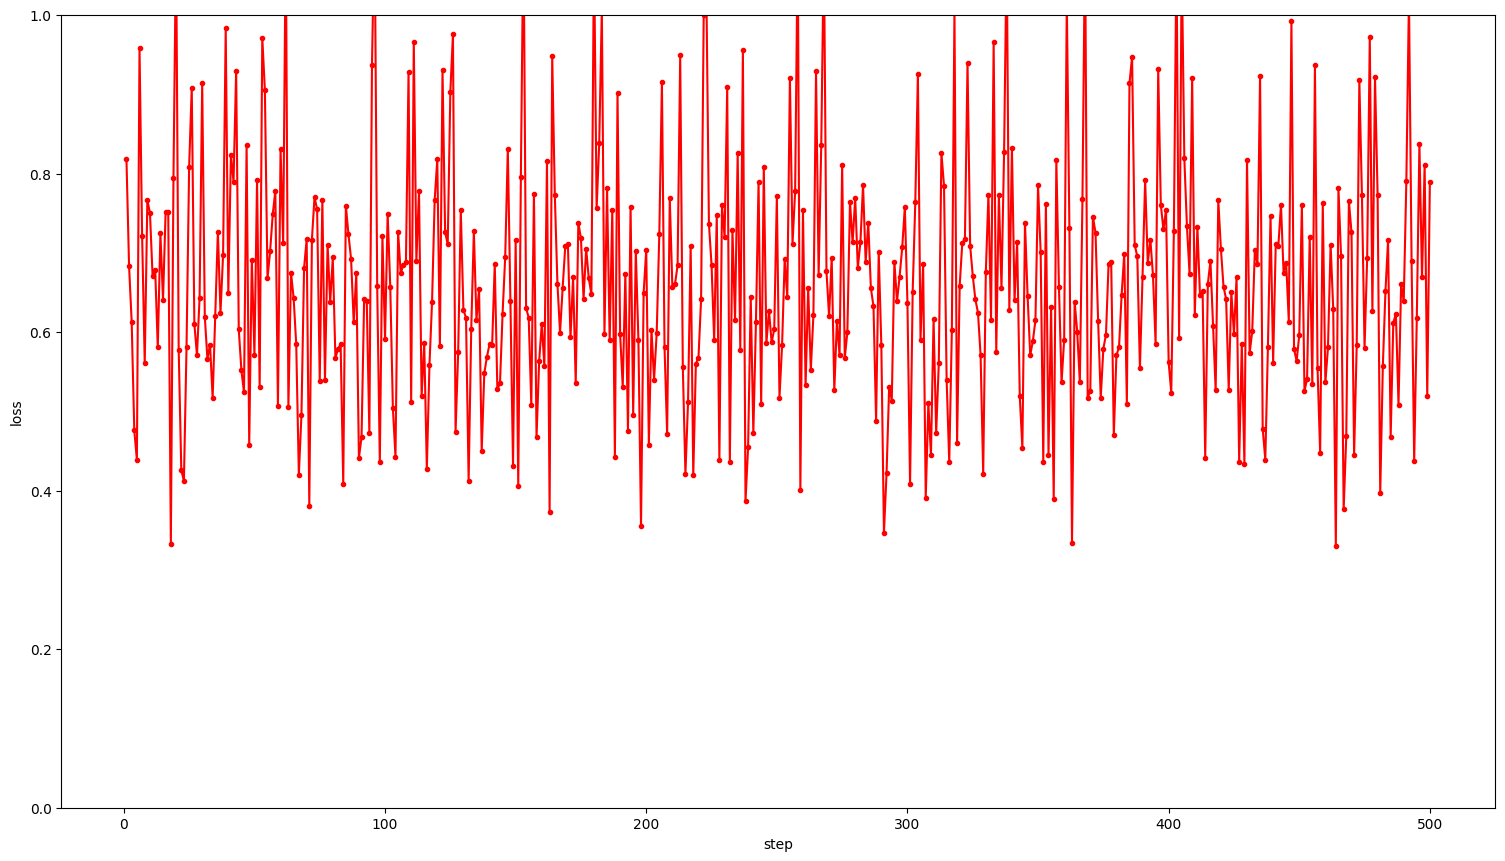

In [15]:
from torch.utils.data import DataLoader
from collections import defaultdict
import time
import argparse
from tqdm import tqdm
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler
"""
def print_metrics(metrics, epoch_samples, phase='train'):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def calc_loss(pred,target,metrics,bce_weight=0.5) :
    #bce = F.binary_cross_entropy_with_logits(pred,target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred,target) 

    #loss = bce * bce_weight + dice * (1 - bce_weight)
    

    metrics['bce'] += 1#bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += 1#loss.data.cpu().numpy() * target.size(0)

    return metrics['loss']
"""
checkpoint_path = "checkpoint.pth"
data_path = '/content/drive/MyDrive/data/train/'
num_workers = 2
batch_size = 2
"""
#what does data loader do?
Dataset stores the samples and their corresponding labels, and 
DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

"""

def train_net(model,
              device,
              epochs: int =5,
              batch_size: int = 1,
              learning_rate: float = 0.001,
              #val_percent: float = 0.1,
              #save_checkpoint: bool = True,
             # img_scale: float = 0.5,
              amp: bool = False
):
#print("training the network...")
# Fetch images and labels.
  model.train()  #funciton of the module superclass ..sets the model to train.
  train_set = TrainDataset(data_path)
  training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
 # https://github.com/milesial/Pytorch-UNet/blob/master/train.py 

  optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
  grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
  criterion = nn.CrossEntropyLoss()
  if isinstance(criterion,torch.nn.Module): ##just to be sure that criterion is on the correct device.
    criterion.to(device)
  global_step = 0
  steps =[]
  losses=[]
  for epoch in range(epochs) :
    #torch.set_grad_enabled(True)
    epoch_samples = 0
    epoch_loss=0
    metrics = defaultdict(float)
    since = time.time()
  
    with tqdm(len(train_set), desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:     
      for iteration, sample in enumerate(training_data_loader):
          img, mask = sample
          img=img.unsqueeze(0)
          img  = img.to(device = device)
          mask = mask.squeeze(1)
          mask = mask.to(device,dtype = torch.long)

      
          #mask = F.one_hot(mask,4).permute(0,3,1,2).float()
          #print(mask.shape)
          """
          torch.cuda.amp and torch provide convenience methods for mixed precision,
          where some operations use the torch.float32 (float) datatype and other operations use torch.float16 (half).
          Some ops, like linear layers and convolutions, are much faster in float16. 
          Other ops, like reductions, often require the dynamic range of float32. 
          Mixed precision tries to match each op to its appropriate datatype.
          """
          #with torch.cuda.amp.autocast(enabled = amp)
          out  = model(img)
          #print(out.shape)
          loss = criterion (out,mask) # +dice_loss(F.softmax(out,dim=1).float(),
                                                  #mask,multiclass = True)
    
    # Then write your BACKWARD & OPTIMIZE below
    # Note: Compute Loss and Optimize
    #loss = criterion(out,mask)
    #loss_value = loss.item()
    #train_losses.append(loss_value)
    #loss.backward()
          optimizer.zero_grad(set_to_none=True)
          grad_scaler.scale(loss).backward()
          grad_scaler.step(optimizer)
          grad_scaler.update()

          pbar.update(img.shape[0])
          global_step += 1
          epoch_loss += loss.item()
          losses.append(loss.item())
          steps.append(global_step)

          #experiment.log({
           #         'train loss': loss.item(),
            #        'step': global_step,
             #       'epoch': epoch
               # })
          print('train loss',loss.item(),' step :',global_step,' epoch :',epoch)
          pbar.set_postfix(**{'loss (batch)': loss.item()})
  plt.plot(steps,losses,'.r-')
  plt.xlabel("step")
  plt.ylabel("loss")
  x1,x2,y1,y2 = plt.axis()  
  plt.axis((x1,x2,0,1))
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5, forward=True)
  fig.set_dpi(100)
  plt.show()
train_net(model,device)

    

### 2.5 Testing

When validating the trained checkpoints (models), remember to change the model status as **Evaluation Mode**

In [ ]:
import numpy as np
from torch.autograd import Variable

In [ ]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
data_path = './data/test'
num_workers = 4
batch_size = 2

test_set = TestDataset(data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

for iteration, sample in enumerate(test_data_loader):
    img = sample
    print(img.shape)

    plt.imshow(img[0,...].squeeze(), cmap='gray') #visualise all images in test set
    plt.pause(1)

## 3 Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 3.1 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

In [ ]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

### 3.2 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [ ]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()